This is a simple example of shape optimization with lumopt. This tutorial gives an example of how to utilize a cubic spline for parametric shape optimization. We'll use a 2D y-splitter as a demonstration.

Here we also explore the differences between the DEPS and the non-DEPS methods in Lumerical inverse design for shape optimization. 

In [1]:
import os, sys
sys.path.append('../../')
from config import Config
sys.path.append(Config.LUMERICAL_API_PATH) # if this fails adjust the config.py and add the lumerical api path

In [2]:
import numpy

In [3]:
import numpy as np
import scipy as sp

import lumapi
from lumopt.utilities.wavelengths import Wavelengths
import lumopt.utilities.wavelengths as w1
from lumopt.geometries.polygon import FunctionDefinedPolygon
from lumopt.utilities.materials import Material
from lumopt.figures_of_merit.modematch import ModeMatch
from lumopt.optimizers.generic_optimizers import ScipyOptimizers
from lumopt.optimization import Optimization
from lumopt.geometries.polygon import FunctionDefinedPolygon
from lumopt.geometries.geometry import Geometry
from lumopt_gl.geometries.geometry_gl import Geometry_GL

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


CONFIGURATION FILE {'root': 'C:\\Program Files/Lumerical/v232/api/python', 'lumapi': 'C:/Program Files/Lumerical/v232/api/python'}


Import the base script. This file contains static elements of the optimization such as input and output waveguides, the source, the FOM monitor, etc.

This file can be an LSF file directly. But its best practice to use a python file so that certain characteristics can be adjustable without editing the base script directly.

In [1]:
from base_scripts.varFDTD_y_branch import y_branch_init_
y_branch_base = y_branch_init_

ModuleNotFoundError: No module named 'base_scripts'

Define the Polygon and the parameters.

Here, we use a spline with 10 control points. Note that the first and last points in the spline are invariant and should not be passed as parameters.

In [4]:
# Define and initialize control points for the spline
initial_points_y = np.linspace(0.25e-6, 0.6e-6, 10)

# Remove the first and last elements. Since these are fixed points.
initial_params_y = initial_points_y[1:-1]

# define the spline function that will be called and updated at each optimization loop:

def taper_splitter(params = initial_params_y):
    initial_points_x = np.linspace(-1.0e-6, 1.0e-6, 10)
    
    # reconstruct the spline
    points_x = np.concatenate(([initial_points_x.min()], initial_points_x[1:-1], [initial_points_x.max()]))
    points_y = np.concatenate(([initial_points_y[0]], params, [initial_points_y[-1]]))
    
    # interpolate between control points
    n_interpolation_points = 100
    polygon_points_x = np.linspace(min(points_x), max(points_x), n_interpolation_points)
    interpolator = sp.interpolate.interp1d(points_x, points_y, kind = 'cubic')
    polygon_points_y = interpolator(polygon_points_x)
    
    # zip the coordinates
    polygon_points_up = [(x, y) for x, y in zip(polygon_points_x, polygon_points_y)]
    polygon_points_down = [(x, -y) for x, y in zip(polygon_points_x, polygon_points_y)]
    polygon_points = np.array(polygon_points_up[::-1] + polygon_points_down)
    
    return polygon_points

# state the bounds
bounds = [(0.2e-6, 0.8e-6)] * initial_params_y.size

Its a good idea to visualize the polygon. We will use the geometry visualizer script.

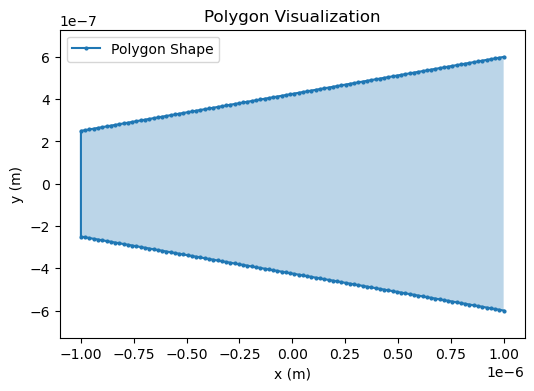

In [5]:
from scripts.geo_visualizer import visualize_func_polygon

visualize_func_polygon(taper_splitter, initial_params_y)

Add materials for core and cladding

In [6]:
eps_in = Material(name = 'Si: non-dispersive')
eps_out = Material(name = 'SiO2: non-dispersive')

The FunctionDefinedPolygon object takes in the function that is updated at each optimization loop, the initial parameters, the bounds, and shape/material information.

In [7]:
polygon = FunctionDefinedPolygon(func = taper_splitter, initial_params = initial_params_y, bounds = bounds, z = 0.0, depth = 220e-9, eps_out = eps_out, eps_in = eps_in)

Define the figure of merit. Generally, we should define the monitor to be used as the figure of merit in the base script

Then define the optimizer. For now we'll use LBFGSB.

Define the wavelengths over which we'd like to optimize.

In [8]:
# define figure of merit
fom = ModeMatch(monitor_name = 'fom', mode_number = 'Fundamental mode', direction = 'Forward', multi_freq_src = True, target_T_fwd = lambda wl: np.ones(wl.size), norm_p = 1)

optimizer = ScipyOptimizers(max_iter = 10, method = 'L-BFGS-B', scaling_factor = 1e6, pgtol = 1e-5)

wavelengths = Wavelengths(start = 1500e-9, stop = 1600e-9, points = 11)


Finally the optimization object. For now, we'll set use_deps to True. Deps is an approximation method that uses the sensitivity map to approximate the gradients for individual parameters. We'll use varFDTD.

In [9]:
opt = Optimization(base_script = y_branch_base, wavelengths = wavelengths, fom = fom, geometry = polygon, optimizer = optimizer, use_var_fdtd=True, hide_fdtd_cad = False, use_deps = True, store_all_simulations = False)

Accurate interface detection enabled


Wavelength range of source object will be superseded by the global settings.
Running scipy optimizer
bounds = [[0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]]
start = [0.28888889 0.32777778 0.36666667 0.40555556 0.44444444 0.48333333
 0.52222222 0.56111111]
Making forward solve
Making adjoint solve
Running solves
Processing forward solve
FOM = 0.7082067095783084
Processing adjoint solve
Calculating gradients
Getting d eps: dx = 1e-10
........
Saved frame
Making forward solve
Making adjoint solve
Running solves
Processing forward solve
FOM = 0.5448317931686166
Processing adjoint solve
Calculating gradients
Getting d eps: dx = 1e-10
........
Making forward solve
Making adjoint solve
Running solves
Processing forward solve
FOM = 0.8759738398172604
Processing adjoint solve
Calculating gradients
Getting d eps: dx = 1e-10
........
Saved frame
Making forward solve
Making adjoint solve
Running solves
Processing forward solve


UserWarning: FDTD simulation did not complete successfully: status 0.0

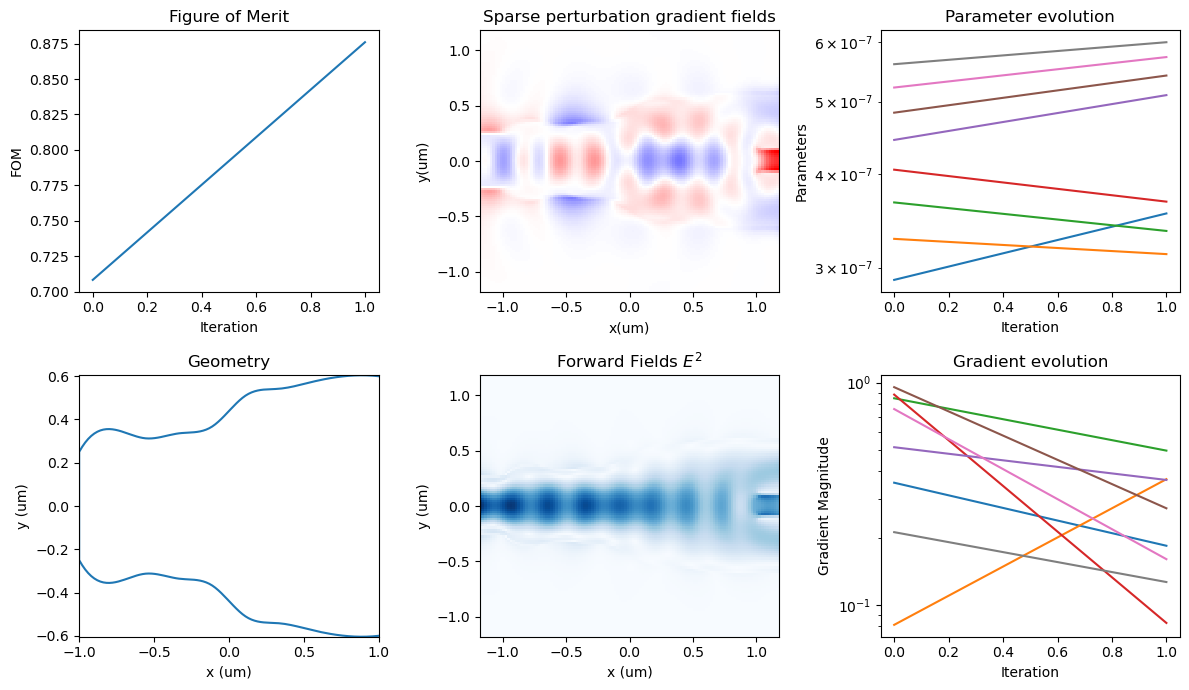

In [10]:
opt.run(working_dir=f'{Config.RESULTS_PATH}/opts')

Finally, we will set deps to false. This will use the differential method of boundary perturbation instead. By use_deps = True, it means to use perturbation and approximation methods of calculating gradient fields. This doesnt require additional simulations but still takes some time per parameter.  When false, the optimizer uses Owen Miller's analytical solution for shape optimization.


In [11]:
initial_points_y = np.linspace(0.25e-6, 0.6e-6, 30) # use more parameters, since its differentiable.
initial_params_y = initial_points_y[1:-1]


def taper_splitter(params = initial_params_y):
    initial_points_x = np.linspace(-1.0e-6, 1.0e-6, 30)
    
    # reconstruct the spline
    points_x = np.concatenate(([initial_points_x.min()], initial_points_x[1:-1], [initial_points_x.max()]))
    points_y = np.concatenate(([initial_points_y[0]], params, [initial_points_y[-1]]))
    
    # interpolate between control points
    n_interpolation_points = 100
    polygon_points_x = np.linspace(min(points_x), max(points_x), n_interpolation_points)
    interpolator = sp.interpolate.interp1d(points_x, points_y, kind = 'cubic')
    polygon_points_y = interpolator(polygon_points_x)
    
    # zip the coordinates
    polygon_points_up = [(x, y) for x, y in zip(polygon_points_x, polygon_points_y)]
    polygon_points_down = [(x, -y) for x, y in zip(polygon_points_x, polygon_points_y)]
    polygon_points = np.array(polygon_points_up[::-1] + polygon_points_down)
    
    return polygon_points

# state the bounds
bounds = [(0.2e-6, 0.8e-6)] * initial_params_y.size

polygon = FunctionDefinedPolygon(func = taper_splitter, initial_params = initial_params_y, bounds = bounds, z = 0.0, depth = 220e-9, eps_out = 1.44**2, eps_in = 3.48**2)

opt2 = Optimization(base_script = y_branch_base, wavelengths = wavelengths, fom = fom, geometry = polygon, optimizer = optimizer, use_var_fdtd=True, hide_fdtd_cad = False, use_deps = False, store_all_simulations = False)

Since Lumopt doesnt support penalty and smoothness filters my default, the result may not look great. 

In [13]:
opt2.run(working_dir=f'{Config.RESULTS_PATH}/opts')

Wavelength range of source object will be superseded by the global settings.
Running scipy optimizer
bounds = [[0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]]
start = [0.26206897 0.27413793 0.2862069  0.29827586 0.31034483 0.32241379
 0.33448276 0.34655172 0.35862069 0.37068966 0.38275862 0.39482759
 0.40689655 0.41896552 0.43103448 0.44310345 0.45517241 0.46724138
 0.47931034 0.49137931 0.50344828 0.51551724 0.52758621 0.53965517
 0.55172414 0.5637931  0.57586207 0.58793103]
Making forward solve
Making adjoint solve
Running solves
Processing forward solve
FOM = 0.7087081530842695
Processing adjoint solve
Calculating gradients
Calculating gradients for 200 edges
.....................................................................

LumApiError: 'Failed to put variable'

<Figure size 640x480 with 0 Axes>